In [1]:
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Project
# Copyright: Zhaoshuo Li, Ding Hao, Mingyi Zheng
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
import torchvision.transforms.functional as TF

import copy
import numpy as np
import random
from tensorboardX import SummaryWriter

import transforms
from dataset import *
from visualization import *
from label_conversion import *
from dice_loss import *
from model_trainning import *

from unet import *

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


# Seed pytorch and numpy and random

In [3]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pretrain_seed = 128

## Hyperparameters

In [4]:
train_batch_size = 10
validation_batch_size=10
learning_rate = 0.001
num_epochs = 70
num_class = 12

## Network

In [5]:
# initialize model
model = unet(useBN=True)
model.to(device)

unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

## Optimizer and Scheduler

In [6]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [9]:
dice_loss = DICELoss(np.ones((num_class,1))) 

## Baseline, without augmentation

In [8]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [7]:
# define transform
train_dataset=MICCAIDataset(data_type = "train", transform=None)
validation_dataset=MICCAIDataset(data_type = "validation", transform=None)
label_converter = LabelConverter()

# # show one example
# img,label = train_dataset.__getitem__(0)
# imshow(img.permute(1,2,0),denormalize=True)
# colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
# imshow(colorlabel)

# # show one example
# img,label = validation_dataset.__getitem__(0)
# imshow(img.permute(1,2,0),denormalize=True)
# colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
# imshow(colorlabel)

In [8]:
# intialize the dataloader
train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

## start training

Training Started!

EPOCH 1 of 70

0 torch.Size([10, 3, 256, 320]) torch.Size([10, 1, 256, 320])


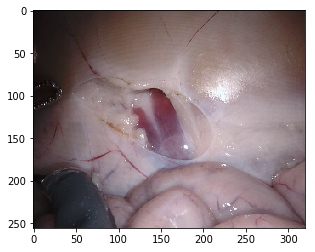

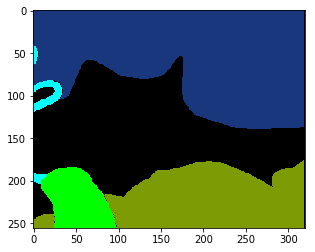

Epoch Loss: 0.0067
----------
1
0 torch.Size([10, 3, 256, 320]) torch.Size([10, 1, 256, 320])


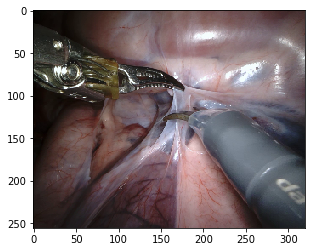

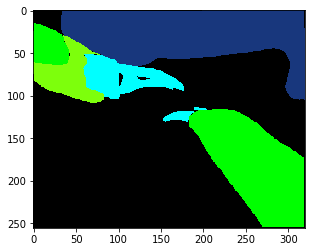

Vaildation Loss: 0.0266
0 Class, True Pos 0.0, False Pos 0.0, Flase Neg 399413.0
1 Class, True Pos 0.0, False Pos 0.0, Flase Neg 53976.0
2 Class, True Pos 0.0, False Pos 0.0, Flase Neg 32922.0
3 Class, True Pos 0.0, False Pos 0.0, Flase Neg 16435.0
4 Class, True Pos 0.0, False Pos 0.0, Flase Neg 44518.0
5 Class, True Pos 121360.0, False Pos 697840.0, Flase Neg 0.0
6 Class, True Pos 0.0, False Pos 0.0, Flase Neg 2840.0
7 Class, True Pos 0.0, False Pos 0.0, Flase Neg 2532.0
8 Class, True Pos 0.0, False Pos 0.0, Flase Neg 0.0
9 Class, True Pos 0.0, False Pos 0.0, Flase Neg 0.0
10 Class, True Pos 0.0, False Pos 0.0, Flase Neg 137911.0
11 Class, True Pos 0.0, False Pos 0.0, Flase Neg 7293.0
----------


RuntimeError: CUDA error: out of memory

In [11]:
print("Training Started!")

# Initialize the visualization environment
writer = SummaryWriter()

# initialize best_acc for comparison
best_acc = 0.0
train_iter = 0
val_iter = 0

for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    # train
    train_loss, train_iter = train(model,device,scheduler,optimizer,dice_loss,train_generator,train_dataset,writer,train_iter)
    print(train_iter)

    # validate
    with torch.no_grad():
        validation_loss, tp, fp, fn, val_iter = validate(model,device,dice_loss,num_class,validation_generator,validation_dataset,writer,val_iter)
        epoch_acc = (2*tp + 1e-7)/ (2*tp+fp+fn+1e-7)
        epoch_acc = epoch_acc.mean()
    
        # loss
        writer.add_scalar('data/Training Loss (per epoch)',train_loss,epoch)
        writer.add_scalar('data/Validation Loss (per epoch)',validation_loss,epoch)
        
        # randomly show one validation image 
        sample = validation_dataset.__getitem__(random.randint(0,len(validation_dataset)-1))
        img = sample[0]*0.5+0.5
        label = sample[1]
        tmp_img = sample[0].reshape(1,3,256,320)
        pred = functional.softmax(model(tmp_img.cuda()), dim=1)
        pred_label = torch.max(pred,dim=1)[1]
        pred_label = pred_label.type(label.type())
        # to plot
        tp_img = np.array(img)
        tp_label = train_dataset.label_converter.label2color(label.permute(1,2,0)).transpose(2,0,1)
        tp_pred = train_dataset.label_converter.label2color(pred_label.permute(1,2,0)).transpose(2,0,1)
        
        writer.add_image('Input', tp_img, epoch)
        writer.add_image('Label', tp_label, epoch)
        writer.add_image('Prediction', tp_pred, epoch)
        
        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

In [ ]:
## load best model weights
model.load_state_dict(best_model_wts)
## save model
# torch.save(model.state_dict(), 'vanilla_trained_unet.pt')

In [10]:
# load test dataset
test_dataset=MICCAIDataset(data_type = "train", transform=None)
test_generator=DataLoader(test_dataset,shuffle=False,batch_size=4,num_workers=8)

In [11]:
# load model
model = unet(useBN=True)
model.load_state_dict(torch.load('vanilla_trained_unet.pt'))
model.to(device)

RuntimeError: CUDA error: out of memory

In [ ]:
final_dice = test(model,device,dice_loss,num_class,test_generator)

# Data Augmentation

# Pretraining